Available player records:
      Player  Wyscout id       Team
92  S. Nypan    0.081967  Rosenborg
Available player records:
      Player  Wyscout id          Team
96  H. Evjen    0.901639  Bodø / Glimt
Selected player ID: 92
Selected player ID: 96
Stat: Progressive runs per 90, Percentile: 1.00
Stat: Smart passes per 90, Percentile: 1.00
Stat: Assists per 90, Percentile: 0.98
Stat: Offensive duels per 90, Percentile: 0.98
Stat: Through passes per 90, Percentile: 0.98
Stat: Successful attacking actions per 90, Percentile: 0.95
Stat: Accelerations per 90, Percentile: 0.95
Stat: Goals per 90, Percentile: 0.93
Stat: Average long pass length, m, Percentile: 0.93
Stat: Defensive duels won, %, Percentile: 0.92
Stat: Assists per 90, Percentile: 1.00
Stat: Key passes per 90, Percentile: 0.98
Stat: Accurate crosses from left flank, %, Percentile: 0.98
Stat: Touches in box per 90, Percentile: 0.97
Stat: Back passes per 90, Percentile: 0.97
Stat: xA per 90, Percentile: 0.97
Stat: Deep completed cr

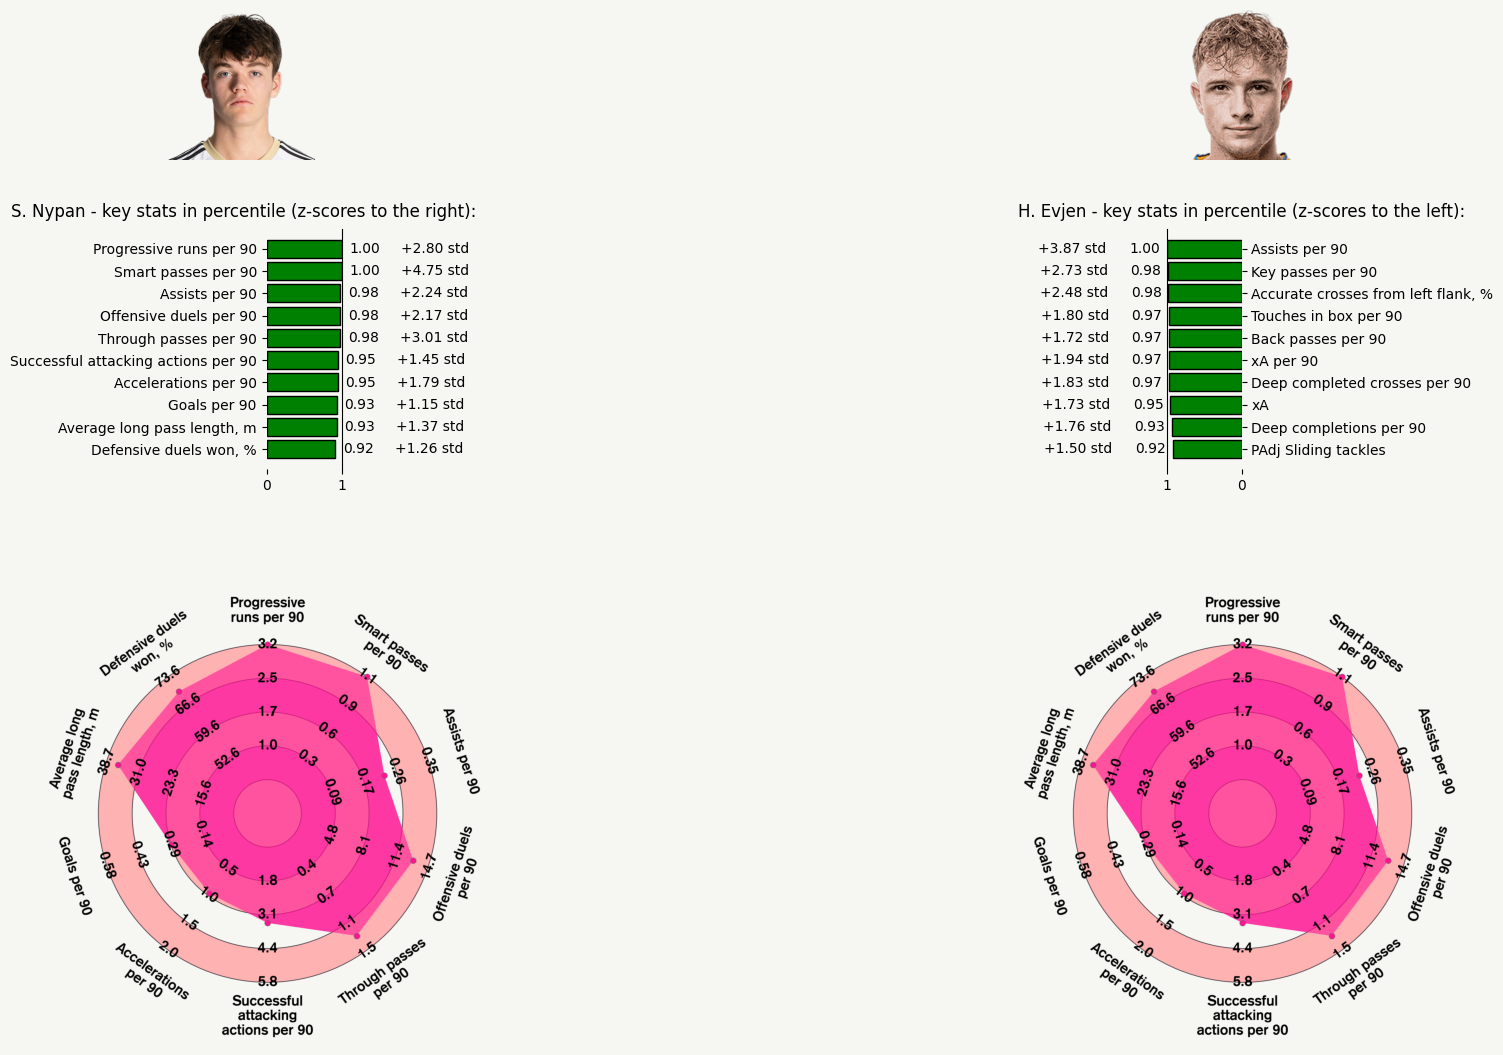

<Figure size 1348.42x1400 with 0 Axes>

<Figure size 1348.42x1400 with 0 Axes>

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import requests
from matplotlib import font_manager
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
import seaborn as sns
import json
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import plotly.express as px
import os
import re
from tabulate import tabulate
from math import pi
from soccerplots.radar_chart import Radar
from mplsoccer import Radar, FontManager, grid
import matplotlib.image as mpimg
from scipy import stats



''' Set the folder path where the csv files are stored: '''
folder_path = r'C:\Users\Sander\Downloads\Wyscout_Prospect_Research-main1\Wyscout_Prospect_Research-main\Main App\Eliteserien 2024.csv'

# ''' Get all the csv files in the folder: '''
# csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')
#             #  and ('23' in f or '24' in f or '25' in f)
#             ]


''' Create an empty list to store the dataframes: '''
# dfs = []

# ''' Read all the csv files in the folder: '''
# for file in csv_files:
#     file_path = os.path.join(folder_path, file)
#     df = pd.read_csv(file_path)
#     dfs.append(df)
    
# ''' Combine all the dataframes into one big dataframe: '''
# combined_df = pd.concat(dfs,
#                         ignore_index=True
#                         )

''' Save the combined dataframe to a csv file: '''
# combined_df.to_csv(r'C:\Users\Sander\Downloads\combined_all_leagues.csv', index=False)

combined_df = pd.read_csv(folder_path)

positions = ['gk', 'cb', 'rb', 'lb', 'cm', 'dmf', 'am', 'w', 'cf']

cm = combined_df[
    combined_df['Position'].str.contains('cm', case=False) & 
    (combined_df['Minutes played'] > 500)]

cm_percentile = cm.copy()
cm_zscores = cm.copy()
for column in cm.select_dtypes(include=['float', 'int']).columns:
    cm_percentile[column] = cm[column].rank(pct=True)
    cm_zscores[column] = stats.zscore(cm[column])


# Get user input for player name
# user_input_player_1 = input('Enter the first player name on the form x.x: ')
# user_input_player_2 = input('Enter the second player name on the form x.x: ')


user_input_player_1 = 'S. Nypan'
percentiles_player_1 = cm_percentile[cm_percentile['Player'] == user_input_player_1]
cm_zscores_player_1 = cm_zscores[cm_zscores['Player'] == user_input_player_1]
user_input_player_2 = 'H. Evjen'
percentiles_player_2 = cm_percentile[cm_percentile['Player'] == user_input_player_2]
cm_zscores_player_2 = cm_zscores[cm_zscores['Player'] == user_input_player_2]


''' LET YOU CHOOSE THE PLAYER RECORD YOU WANT IF THERE ARE MULTIPLE RECORDS FOR THE SAME PLAYER '''
def get_player_id(percentiles_player):
    if not percentiles_player.empty:
        print("Available player records:")
        print(percentiles_player[['Player', 'Wyscout id', 'Team']])

        if len(percentiles_player) > 1:
            try:
                choice = int(input(f"Enter the number of the correct record (1-{len(percentiles_player)}): ")) - 1
                if 0 <= choice < len(percentiles_player):
                    return percentiles_player.index[choice]
                else:
                    print("Invalid choice.")
                    return None
            except ValueError:
                    print("Invalid input. Please enter a number.")
                    return None
        else:
                # If only one record is found, return its ID
            return percentiles_player.index[0]
    else:
        print("Player not found.")
        return None
    
player_id_1 = get_player_id(percentiles_player_1)
player_id_2 = get_player_id(percentiles_player_2)
print(f"Selected player ID: {player_id_1}")
print(f'Selected player ID: {player_id_2}')


# Check if the player exists in the DataFrame
if not percentiles_player_1.empty and not percentiles_player_2.empty and not cm_zscores_player_1.empty and not cm_zscores_player_2.empty:
    
    columns_to_drop = ['Player', 'Wyscout id', 'Team', 'Position', 'Primary position', 'Primary position, %', 'Weight', 'Height', 'Team within selected timeframe', 
                       'Market value', 'Minutes played', 'Age', 'Secondary position', 'Third position', 'Yellow cards', 'Red cards',
                       'Assists', 'Goals', 'Fouls suffered per 90', 'Direct free kicks on target, %', 'Penalty conversion, %', 'Corners per 90', 'Direct free kicks per 90']
    # Get the percentile values for the player, excluding the 'Player' column
    top_stats_player_1 = percentiles_player_1.drop(columns = columns_to_drop, errors='ignore').T  # Transpose to have stats as rows
    top_stats_player_2 = percentiles_player_2.drop(columns = columns_to_drop, errors='ignore').T  # Transpose to have stats as rows

    top_stats_player_1 = top_stats_player_1.apply(pd.to_numeric, errors='coerce').dropna()
    top_stats_player_2 = top_stats_player_2.apply(pd.to_numeric, errors='coerce').dropna()
    
    # Get the top ten stats based on the percentile values
    top_ten_stats_player_1 = top_stats_player_1.nlargest(10, top_stats_player_1.columns[0])
    top_ten_stats_player_2 = top_stats_player_2.nlargest(10, top_stats_player_2.columns[0])
    # Display the results
    for stat, value in top_ten_stats_player_1.iterrows():
        print(f"Stat: {stat}, Percentile: {value.values[0]:.2f}")
        
    for stat, value in top_ten_stats_player_2.iterrows():
        print(f"Stat: {stat}, Percentile: {value.values[0]:.2f}")
else:
    print("Player not found.")
    



# position_input = input('Select position from: CF, W, AM, CM, DM, WB, CB, GK')
# if position_input == 'CF':
#     params = ['Goals per 90', 'xG', 'Non-penalty goals per 90', 'Shots on target, %', 'Goal conversion, %', 
#               'Successful attacking actions per 90', 'Progressive runs per 90', 'Touches in box per 90']
# elif position_input == 'W' or position_input == 'AM':
#     params = ['Successful attacking actions per 90','Successful dribbles, %', 'Accelerations per 90', 
#                 'Offensive duels won, %', 'Progressive runs per 90', 'Touches in box per 90']
# elif position_input == 'CM':
    # params = ['Successful attacking actions per 90','Successful dribbles, %', 'Accelerations per 90', 
    #           'Progressive runs per 90', 'Touches in box per 90']
    
params= top_ten_stats_player_1.index
params_2 = top_ten_stats_player_2.index

ranges = []
min_val = []
max_val = []
for x in params:
    min_val.append(cm[x].min())
    max_val.append(cm[x].max())
    # ranges.append((min_val - (0.25 * min_val), max_val + (0.25 * max_val)))

radar = Radar(params, min_val, max_val,
            # whether to round any of the labels to integers instead of decimal places
            round_int=[False]*len(params),
            num_rings=4,  # the number of concentric circles (excluding center circle)
            # if the ring_width is more than the center_circle_radius then
            # the center circle radius will be wider than the width of the concentric circles
            ring_width=1, center_circle_radius=1)        
        
URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

font = font_manager.FontProperties(fname=r'C:\Users\Sander\Downloads\Akzidenz-Grotesk-Font\Akzidenz Grotesk Font\Akzidenz-grotesk-bold.ttf')



def save_figure(fig, folder_path, filename):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
          # Create the full file path
    file_path = os.path.join(folder_path, filename)

    # Save the figure
    fig.savefig(file_path)
    # plt.close(fig)  # Close the figure after saving
    




''' RADAR PLOT 1'''
def plot_radar_1():
        
    compare = cm.loc[cm['Player'] == user_input_player_1, params].values[0]

    # creating the figure using the grid function from mplsoccer:
    fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                    title_space=0, endnote_space=0, grid_key='radar', axis=False)

    # plot the radar
    radar.setup_axis(ax=axs['radar'], facecolor='#F6F6F2')
    rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#39353f', lw=1.5)
    radar_output = radar.draw_radar(compare, ax=axs['radar'],
                                            kwargs_radar={'facecolor': '#FF1493', 'alpha': 0.6},
                                            kwargs_rings={'facecolor': '#FF1493', 'alpha': 0.6})
    radar_poly, rings_outer, vertices1 = radar_output
    range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=30, color='black',
                                        fontproperties=font)
    param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=30, color='black',
                                        fontproperties=font)
    axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                        c='#FF1493', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

    # adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
    # Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
    # endnote_text = axs['endnote'].text(0.99, 0.5, '@Fotbadlstat on X',
    #                                 color='#a3c2a8', fontproperties=rubik_regular.prop,
    #                                 fontsize=13, ha='right', va='center')
    # title1_text = axs['title'].text(0.01, 0.65, percentiles_player_1['Player'].values[0], fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title2_text = axs['title'].text(0.01, 0.25, f'{percentiles_player_1['Team within selected timeframe'].values[0]} | {cm.loc[cm['Player'] == user_input_player_1, 'Age'].values[0]} years old', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title3_text = axs['title'].text(0.99, 0.65, f'Primary position: {percentiles_player_1['Primary position'].values[0]}', fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='right', va='center', color='#FF1493')
    # title4_text = axs['title'].text(0.99, 0.25, f'Minutes played: {cm.loc[cm['Player'] == user_input_player_1, 'Minutes played'].values[0]}', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='right', va='center', color='#FF1493')

    fig.set_facecolor('#F6F6F2')
    
    
    # player_folder = f"{percentiles_player_1['Player'].values[0]}_compare"
    # folder_path = os.path.join(r'C:\Users\Sander\Documents\football_analytics\scouting', player_folder)

    # # Create the filename and save the figure
    # filename = f"{percentiles_player_1['Player'].values[0]} vs {percentiles_player_2['Player'].values[0]}.png"
    
    # # Save the figure and ensure folder exists
    # save_figure(fig, folder_path, filename)

    return fig, axs



''' RADAR PLOT 2'''
def plot_radar_2():
        
    compare = cm.loc[cm['Player'] == user_input_player_2, params_2].values[0]

    # creating the figure using the grid function from mplsoccer:
    fig2, axs2 = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                    title_space=0, endnote_space=0, grid_key='radar', axis=False)

    # plot the radar
    radar.setup_axis(ax=axs2['radar'], facecolor='#F6F6F2')
    rings_inner = radar.draw_circles(ax=axs2['radar'], facecolor='#ffb2b2', edgecolor='#39353f', lw=1.5)
    radar_output = radar.draw_radar(compare, ax=axs2['radar'],
                                            kwargs_radar={'facecolor': '#FF1493', 'alpha': 0.6},
                                            kwargs_rings={'facecolor': '#FF1493', 'alpha': 0.6})
    radar_poly, rings_outer, vertices1 = radar_output
    range_labels = radar.draw_range_labels(ax=axs2['radar'], fontsize=30, color='black',
                                        fontproperties=font)
    param_labels = radar.draw_param_labels(ax=axs2['radar'], fontsize=30, color='black',
                                        fontproperties=font)
    axs2['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                        c='#FF1493', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

    # adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
    # Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
    # endnote_text = axs['endnote'].text(0.99, 0.5, '@Fotbadlstat on X',
    #                                 color='#a3c2a8', fontproperties=rubik_regular.prop,
    #                                 fontsize=13, ha='right', va='center')
    # title1_text = axs['title'].text(0.01, 0.65, percentiles_player_1['Player'].values[0], fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title2_text = axs['title'].text(0.01, 0.25, f'{percentiles_player_1['Team within selected timeframe'].values[0]} | {cm.loc[cm['Player'] == user_input_player_1, 'Age'].values[0]} years old', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title3_text = axs['title'].text(0.99, 0.65, f'Primary position: {percentiles_player_1['Primary position'].values[0]}', fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='right', va='center', color='#FF1493')
    # title4_text = axs['title'].text(0.99, 0.25, f'Minutes played: {cm.loc[cm['Player'] == user_input_player_1, 'Minutes played'].values[0]}', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='right', va='center', color='#FF1493')

    fig2.set_facecolor('#F6F6F2')
    
    
    # player_folder = f"{percentiles_player_1['Player'].values[0]}_compare"
    # folder_path = os.path.join(r'C:\Users\Sander\Documents\football_analytics\scouting', player_folder)

    # # Create the filename and save the figure
    # filename = f"{percentiles_player_1['Player'].values[0]} vs {percentiles_player_2['Player'].values[0]}.png"
    
    # # Save the figure and ensure folder exists
    # save_figure(fig2, folder_path, filename)

    return fig2, axs2





# Main plotting function
def main_plot():
    # Create the main figure for both players
    fig, ax = plt.subplots(figsize=(15, 12))
    fig.set_facecolor('#F6F6F2')
    ax.set_facecolor('#F6F6F2')

    # PLAYER 1
    ax_p1_img = fig.add_axes([0.032, 0.8, 0.1, 0.2])
    ax_p1_img.axis('off')
    player1_image = mpimg.imread(r'C:\Users\Sander\Downloads\S. Nypan.png')
    ax_p1_img.imshow(player1_image)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.text(0.085, 0.79, f'{user_input_player_1} - key stats in percentile (z-scores to the right):', fontsize=12, ha='center')

    ax_p1_bars = fig.add_axes([0.1, 0.58, 0.05, 0.2])
    for i, (stat, percentile) in enumerate(top_ten_stats_player_1.itertuples()):
        ax_p1_bars.barh(stat, percentile, color='green', edgecolor='black')
        ax_p1_bars.text(percentile + 0.1, stat, f'{percentile:.2f}', va='center', ha='left', color='black')
        ax_p1_bars.text(percentile + 1.7, stat, f'+{cm_zscores_player_1[stat].values[0]:.2f} std', va='center', ha='right', color='black')
    ax_p1_bars.set_xlim(0, 1)
    ax_p1_bars.invert_yaxis()
    ax_p1_bars.spines['top'].set_visible(False)
    ax_p1_bars.spines['bottom'].set_visible(False)
    ax_p1_bars.spines['left'].set_visible(False)
    ax_p1_bars.set_facecolor('#F6F6F2')

    # PLAYER 2
    ax_p2_img = fig.add_axes([0.70, 0.8, 0.1, 0.2])
    ax_p2_img.axis('off')
    player2_image = mpimg.imread(r'C:\Users\Sander\Downloads\H. Evjen.png')
    ax_p2_img.imshow(player2_image)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.text(0.75, 0.79, f'{user_input_player_2} - key stats in percentile (z-scores to the left):', fontsize=12, ha='center')

    ax_p2_bars = fig.add_axes([0.7, 0.58, 0.05, 0.2])
    for i, (stat, percentile) in enumerate(top_ten_stats_player_2.itertuples()):
        ax_p2_bars.barh(stat, percentile, color='green', edgecolor='black')
        ax_p2_bars.text(percentile + 0.5, stat, f'{percentile:.2f}', va='center', ha='left', color='black')
        ax_p2_bars.text(percentile + 0.8, stat, f'+{cm_zscores_player_2[stat].values[0]:.2f} std', va='center', ha='right', color='black')
    ax_p2_bars.set_xlim(0, 1)
    ax_p2_bars.invert_yaxis()
    ax_p2_bars.invert_xaxis()
    ax_p2_bars.spines['top'].set_visible(False)
    ax_p2_bars.spines['bottom'].set_visible(False)
    ax_p2_bars.spines['right'].set_visible(False)
    ax_p2_bars.yaxis.tick_right()
    ax_p2_bars.set_facecolor('#F6F6F2')

    ''' RADAR PLOT 1'''
    radar_fig, radar_axs = plot_radar_1()  # Call your radar plotting function
    radar_fig.canvas.draw()  # Ensure the radar figure is drawn before using its buffer
    radar_ax = fig.add_axes([-0.1, 0.1, 0.4, 0.4])  # Adjust [left, bottom, width, height] as needed
    radar_ax.imshow(radar_fig.canvas.buffer_rgba())  # Render radar plot into the new ax
    for ax in radar_axs.values():
        ax.remove()  # Remove original axes if needed
    radar_ax.spines['top'].set_visible(False)
    radar_ax.spines['bottom'].set_visible(False)
    radar_ax.spines['left'].set_visible(False)
    radar_ax.spines['right'].set_visible(False)
    radar_ax.xaxis.set_ticks([])
    radar_ax.yaxis.set_ticks([])
    
    
    
    ''' RADAR PLOT 1'''
    radar_fig_2, radar_axs_2 = plot_radar_2()  # Call your radar plotting function
    radar_fig_2.canvas.draw()  # Ensure the radar figure is drawn before using its buffer
    radar_ax_2 = fig.add_axes([0.55, 0.1, 0.4, 0.4])  # Adjust [left, bottom, width, height] as needed
    radar_ax_2.imshow(radar_fig.canvas.buffer_rgba())  # Render radar plot into the new ax
    for ax2 in radar_axs_2.values():
        ax2.remove()  # Remove original axes if needed
    radar_ax_2.spines['top'].set_visible(False)
    radar_ax_2.spines['bottom'].set_visible(False)
    radar_ax_2.spines['left'].set_visible(False)
    radar_ax_2.spines['right'].set_visible(False)
    radar_ax_2.xaxis.set_ticks([])
    radar_ax_2.yaxis.set_ticks([])

    plt.show()  # Display the final figure

main_plot()





In [ ]:
# def plot_radar():
#     compare = percentiles_player_1[params].values[0]
#     compare_with = percentiles_player_2[params].values[0]

#     # creating the figure using the grid function from mplsoccer:
#     fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
#                     title_space=0, endnote_space=0, grid_key='radar', axis=False)

#     # plot the radar
#     radar.setup_axis(ax=axs['radar'], facecolor='#F6F6F2')
#     rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#39353f', lw=1.5)
#     radar_output = radar.draw_radar_compare(compare, compare_with, ax=axs['radar'],
#                                             kwargs_radar={'facecolor': '#FFD700', 'alpha': 0.6},
#                                             kwargs_compare={'facecolor': '#FF1493', 'alpha': 0.6})
#     radar_poly, radar_poly2, vertices1, vertices2 = radar_output
#     range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=30, color='black',
#                                            fontproperties=font)
#     param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=30, color='black',
#                                            fontproperties=font)
#     axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
#                          c='#FFD700', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)
#     axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
#                          c='#FF1493', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

#     endnote_text = axs['endnote'].text(0.99, 0.5, '@Fotbadlstat on X',
#                                         color='#a3c2a8', fontproperties=rubik_regular.prop,
#                                         fontsize=13, ha='right', va='center')
#     title1_text = axs['title'].text(0.01, 0.65, percentiles_player_1['Player'].values[0], fontsize=25,
#                                      fontproperties=robotto_bold.prop,
#                                      ha='left', va='center', color='#FFD700')
#     title2_text = axs['title'].text(0.01, 0.25, f'{percentiles_player_1["Team within selected timeframe"].values[0]} | ', fontsize=20,
#                                      fontproperties=robotto_thin.prop,
#                                      ha='left', va='center', color='#FFD700')
#     title3_text = axs['title'].text(0.99, 0.65, f'{percentiles_player_2["Player"].values[0]}', fontsize=25,
#                                      fontproperties=robotto_bold.prop,
#                                      ha='right', va='center', color='#FF1493')
#     title4_text = axs['title'].text(0.99, 0.25, f'{percentiles_player_2["Team within selected timeframe"].values[0]} | ', fontsize=20,
#                                      fontproperties=robotto_thin.prop,
#                                      ha='right', va='center', color='#FF1493')

#     fig.set_facecolor('#F6F6F2')
#     return fig, axs